#**Filtro anti-hater per social network**

In questo progetto realizato da me, Alessio Feudo, si affronta un tema complesso e allo stesso tempo attuale: la moderazione dei contenuti sui social network. In particolare, il progetto riguarda la classificazione in vari livelli di tossicità di commenti social. Per lo svolgimento di tale task, si applicheranno modelli a **reti neurali ricorrenti** e anche un modello **Transformer Encoder** semplificato. Questi approcci risultano efficaci ed essenziali per trattare questo tipo di problema, dati sia il vasto volume di commenti generati nel tempo, sia la complessità del linguaggio umano.

Il dataset fornito contiene molti commenti social etichettati con 6 possibili labels, anche presenti in combinazione. Per poter affrontare un problema multilabel come questo, si utilizzano approcci specifici, comprendenti anche apposite librerie, come scikit-multilearn. Inoltre sarà task primario il bilanciamento del dataset, sia utilizzando teniche **NLP** di augmentation, sia implementando una funzione di loss personalizzata, pesata in base alla rappresentazione nel dataset delle varie labels.

Inoltre, il codice è stato pensato per rendere asincrono l'addestramento di un dato modello, andando a salvare lo stato di apprendimento con metriche e altre variabili, in modo da poter riprendere il training in un secondo momento.

In [ ]:
pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
pip install nlpaug


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from skmultilearn.model_selection import iterative_train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import string
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Layer, Input, Embedding, LSTM, Dense, LayerNormalization, GRU, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import Callback
import nltk
from nltk.corpus import stopwords
import nlpaug.augmenter.word as naw
import csv
import pickle
import os

##**Data loading e splitting**
Per preparare il dato alle analisi successive si scarica il dataset, che si presenta in formato multilabel con 6 diverse possibili labels. Per poter dividere il dataset in set di training, validation e test preservando la distribuzione delle label, si usa uno splitting iterativo, assegnando il 20% del dataset al test e l'8% alla validazione. Il set di training viene poi analizzato in praticolare, andando a monitorare la distribuzione delle labels, prestando attenzione alla presenza di sbilanciamento.

In [ ]:
# downloading english stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# downloading pre-trained model for part of speech tagging, used in the following for data augmentation
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# dataset loading
df=pd.read_csv('/content/drive/MyDrive/deep learning/Filter_Toxic_Comments_dataset.csv')
print(df)

                                             comment_text  toxic  \
0       Explanation\nWhy the edits made under my usern...      0   
1       D'aww! He matches this background colour I'm s...      0   
2       Hey man, I'm really not trying to edit war. It...      0   
3       "\nMore\nI can't make any real suggestions on ...      0   
4       You, sir, are my hero. Any chance you remember...      0   
...                                                   ...    ...   
159566  ":::::And for the second time of asking, when ...      0   
159567  You should be ashamed of yourself \n\nThat is ...      0   
159568  Spitzer \n\nUmm, theres no actual article for ...      0   
159569  And it looks like it was actually you who put ...      0   
159570  "\nAnd ... I really don't think you understand...      0   

        severe_toxic  obscene  threat  insult  identity_hate  sum_injurious  
0                  0        0       0       0              0              0  
1                  0       

In [ ]:
# x and y definition
ml_target=['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] # target labels

y=df[ml_target].values #target
x=df['comment_text'] # dataset without target


In [ ]:
#splitting according to x indices
len_df=len(df)
indices=np.arange(len_df).reshape(-1,1)

# train, validation and test sets splitting
print(indices.shape, y.shape)
id_train_tot, y_train_tot, id_test, y_test = iterative_train_test_split(indices, y, test_size=0.2)
print(id_train_tot.shape, y_train_tot.shape)

# train, val
id_train, y_train, id_val, y_val=iterative_train_test_split(id_train_tot, y_train_tot, test_size=0.1)
print(id_train.shape, y_train.shape)

x_train_tot=x[id_train_tot.flatten()]
x_test=x[id_test.flatten()]

x_train=x[id_train.flatten()]
x_val=x[id_val.flatten()]

print(f'Type x_train: {type(x_train)}')

(159571, 1) (159571, 6)
(127656, 1) (127656, 6)
(114890, 1) (114890, 6)
Type x_train: <class 'pandas.core.series.Series'>


In [ ]:
print(y_train, type(y_train))

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] <class 'numpy.ndarray'>


In [ ]:
# x_train analysis
def x_train_label_analysis(y_train, ml_target):
  '''
  The function analyzes train set target to find the label distribution.

  Args:
      - y_train (np.ndarray): train set target
      - ml_target (list): list of target labels

  Returns:
      - (np.ndarray): sum_label_list, storing occurrences of each label in train set
      - (np.ndarray): unique_label_array, storing occurrences of each label in unique target samples
      - (dict): stores (key, value)=(label, list of sample indices having only that label)
  '''

  sum_label_list = [np.sum(y_train[:, id]) for id in range(len(ml_target))]
  # printing tot number of samples with a given label (not unique)
  print(f'N. samples for target:\n{[(lab,int(sum)) for lab, sum in zip(ml_target,sum_label_list)]}\n')
  # printing the number of samples with/without label and their ratio
  print(f'N. samples with label: {sum(sum_label_list)}, N. of sample withount label: {len(y_train)-sum(sum_label_list)}, Ratio neutral/label: {(len(y_train)-sum(sum_label_list))/sum(sum_label_list):.2f}')

  # analysis of unique label samples
  mask_single_label = (y_train.sum(axis=1) == 1) # mask to find samples with only one label
  y_single_label = y_train[mask_single_label] # selecting samples with single label
  labels_active = y_single_label.argmax(axis=1) # recovering the specific label
  unique_label_array=np.zeros(len(ml_target)) # creation of an array to store unique label informations
  for item in labels_active:
     unique_label_array[item]+=1

  # filtering indices of each unique label samples
  indices_single_label = np.where(mask_single_label)[0] # indices of single label samples
  samples_per_label = {label: [] for label in ml_target} # dictionary to store the indices of unique label samples for each label
  for sample_idx, label_idx in zip(indices_single_label, labels_active):
    label = ml_target[label_idx]
    samples_per_label[label].append(sample_idx)

  # plot general label distribution
  ml_target_tot=['no_label','toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
  sum_label_tot=sum_label_list.copy()
  sum_label_tot.insert(0, (len(y_train)-sum(sum_label_list))) # computing tot of no-label samples

  plt.bar(ml_target_tot, sum_label_tot)
  plt.xlabel('Label')
  plt.ylabel('Counts')
  plt.title('Label distribution')
  plt.show()

  # printing the number of samples with unique label, for each label
  print(f'N. UNIQUE samples for target:\n{[(lab,int(tot)) for lab, tot in zip(ml_target,unique_label_array)]}\n')

  return np.array(sum_label_list), unique_label_array, samples_per_label



###**Tokenizzazione, Augmentation e Padding**
In questa sezione, il dato subisce le trasformazioni utili ad essere passato ad una rete neurale. In particolare, la prima operazione include la pulizia del dato testuale e lowercasing, eliminando punteggiatura, stopwords e cifre, in modo da ottene un vocabolario finale essenziale.

Oltre ciò, si nota come il set di training sia sbilanciato, sia perchè la classe neutra è maggioritaria, sia perchè considerando le altre classi, queste risultano essere presenti in abbondanze diverse tra loro. Per questo si applica sia augmentation sulle labels minoritarie, sia pesi nella funzione di loss delle reti neurali, come vedremo in seguito. Per l'augmentation, si cercano i samples corrispondenti a singole label: in questo modo aumentando il sample si è certi di aumentare solo la rappresentazione per una data label, avendo più controllo. Prima di tutto si stabilisce che il numero totale di samples con qualche label dovrà arrivare ad essere circa la metà del numero d samples della classe neutra. Quindi si filtrano i samples con unica label e si creano nuovi dati da ognuno di quelli selezionati, in numero dipendente dal numero totale di samples aventi quella label (anche in etichette multilabel), sostituendo il 30% delle parole con sinonimi, utilizzando la libreria **nlpaug**. Si è scelto di arrivare ad avere un numero di samples con label pari a circa la metà di quelli di label neutro, per evitare di introdurre troppi dati sintetici, andando a completare poi il bilanciamento con la funzione di loss usata nelle reti ricorrenti e nell'encoder.

Una volta aumentati i dati, questi vengono trasformati in sequenze di token e paddati: si sceglie cioè la sequenza più lunga, andando a completare tutte le altre con zeri a destra per poter raggiungere la stessa lunghezza. Questo è necessario per dare ai modelli un input omogeneo in dimensioni.

Per augmentation, si sarebbe potuto usare anche MSmote, ma si è scelto di procedere con nlpaug perchè permette una augmentation diretta sulle frasi e non sugli embedding finali, come invece prevederebbe MSmote.

In [ ]:
def text_processing(sentence):
  '''
  The function performs text preprocessing. It applies lower casing and punctuation, stopwords, numbers, multiple spaces remotion.

  Args:
      - sentence (str): the input sentence to preprocess

  Returns:
      - (str): the processed sentence
  '''

  sentence=sentence.lower() #lower case

  for c in string.punctuation:  # puctuation remotion
    sentence=sentence.replace(c," ")

  #stopwords remotion
  words = sentence.split()
  words_no_stopw = [w for w in words if w not in stop_words]
  sentence=' '.join(words_no_stopw)


  sentence=re.sub("\\d"," ", sentence) # numbers remotion
  sentence=re.sub(" +"," ", sentence) # multiple spaces remotion

  return sentence


def augmentation_per_label(x_per_label, no_label_samples, n_only_common_label, n_samples_label, final_ratio=0.5):
  '''
  The function performs augmentation on text samples, using synonym substitution.

  Args:
      - x_per_label (list): list to store cleaned unique label sentences to augment
      - no_label_samples (int): n. of samples without label
      - n_only_common_label (int): n. of samples with multiple labels, including the label investigated at the moment
      - n_samples_label (int): n. of unique plus common label samples
      - final_ratio (float, optional): ratio to achieve between labelled samples and no labelled samples after augmentation. Default to 0.5.
  Returns:
      - (list): list of non-augmented sentences (in case of aboundance matching), list of augmented sentences (in case of abundance deficit)
  '''

  # synonym augmenter: it will replace the 30% of words in the sentence
  aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
  # number of new samples needed to reach a given threshold aboundance
  n_of_needed_samples=int(((final_ratio*no_label_samples)/6)-n_samples_label)
  # if the present aboundance is already enough, the label is not augmented
  if n_of_needed_samples <= 0:
    return x_per_label

  else:
    # if the present aboundance is not enough, augmentation is enabled
    n_copies=n_of_needed_samples // len(x_per_label) # number of copies to extract from each sample of the given label
    x_list=[]

    for id_x,x in enumerate(x_per_label):
       x_list.append(x) # including the 'father' sample in the final list

       for i in range(0,n_copies): # creating n_copies 'son' samples
          x_list.append(aug.augment(x))

  return x_list



def text_to_padded_seq(x_train, x_val, x_test, y_train, vocab_size, ml_target):
  """
  Function to apply various preprocessing steps on train and test/val sentences.
  It cleans text from puctuation, stpwords and numbers, then tokenizes and transforms text in padded sequences,
  after data augmentation on train set.

  Args:
      - x_train (pandas.Series): train set to preprocess
      - x_val (pandas.Series): val set to preprocess
      - x_test (pandas.Series): test set to preprocess
      - y_train (np.ndarray): train target
      - vocab_size (int): max vocabulary size allowed
      - ml_target (list): list of target labels

  Returns:
      - (np.ndarray): x_train transformed and augmented
      - (np.ndarray): x_val transformed
      - (np.ndarray): x_test transformed
      - (np.ndarray): y_train after augmentation
      - (int): train set extracted padded sequences max lenght
      - (obj): tokenizer adopted
      - (np.ndarray): array storing occurrences of each label in train set after augmentation
  """

  #exploring label distribution
  print('1/6--Exploring label train distribution')
  sum_label_array, unique_label_vector, unique_label_indices_dict=x_train_label_analysis(y_train, ml_target)

  # applying text_preprocessing function
  print('2/6--Text preprocessing')
  x_train = [text_processing(text) for text in x_train]
  x_val=[text_processing(text) for text in x_val]
  x_test = [text_processing(text) for text in x_test]

  #saving non tokenized x_val for model evaluation
  with open(f'/content/drive/MyDrive/deep learning/x_val.pkl', 'wb') as f:
    pickle.dump(x_val, f)

  #saving non tokenized x_test for model evaluation
  with open(f'/content/drive/MyDrive/deep learning/x_test.pkl', 'wb') as f:
    pickle.dump(x_test, f)
  print('Done')

  # data augmentation for each minority label: augmentation is performed using unique label samples for each label
  print('\n\n3/6--Data augmentation')
  indices_minority = [] # list to store all the indices of minority labels samples

  # lists to store augmented data
  x_train_aug=[]
  y_train_aug=[]

  print(ml_target)
  samples_with_label=sum(sum_label_array) # n. of samples with label
  samples_no_label=len(x_train)-samples_with_label # n. of samples without label

  # augmentation: loop on each label
  for label_idx, label in enumerate(ml_target):
     if unique_label_vector[label_idx]!=0: # check if the selected label has no unique samples
        print(f'Augmentation for label: {label}')
        indices_label = unique_label_indices_dict[label] # indices of unique label samples for that label
        n_unique_label=len(indices_label) # number of samples with only the considered label

        n_nonunique_label=sum_label_array[label_idx] # single plus common label samples for a given label
        n_only_common_label=n_nonunique_label-n_unique_label # n. of only common label samples

        # extracting samples with unique label
        x_train_lab=[x_train[i] for i in indices_label]
        y_train_lab=y_train[indices_label]

        # invoking augmentation function
        x_train_augmented=augmentation_per_label(x_train_lab, samples_no_label, n_only_common_label, n_nonunique_label)
        y_train_augmented = [y_train_lab[0]] * len(x_train_augmented) # creating targets for augmented samples
        print(y_train_lab[0])

        # augmented data/label concat
        x_train_aug.extend(x_train_augmented)
        y_train_aug.extend(y_train_augmented)

        indices_minority.extend(indices_label)

     else:
        # if unique label samples are not available, the label is not augmented
        print(f'Label {label} not augmented')
        continue

  # Final augmented arrays
  # filtering no label samples
  indices_non_minority = [i for i in range(len(x_train)) if i not in indices_minority]
  x_train_non_minority = [x_train[i] for i in indices_non_minority]
  y_train_non_minority = list(y_train[indices_non_minority])

  x_train_final = x_train_non_minority + x_train_aug # rebuilding x_train, adding together augmented and no label samples
  y_train_final = np.array(y_train_non_minority + y_train_aug)
  assert len(x_train_final)==len(y_train_final), 'Augmentation failure!' # augmentation check
  print(f'x_train lenght before augmentatoin: {len(x_train)}\nx_train lenght after augmentatoin: {len(x_train_final)}')

  #rename and aboundance check
  x_train=x_train_final
  y_train=y_train_final
  sum_label_array_aug, unique_label_vector_aug, unique_label_indices_dict_aug= x_train_label_analysis(y_train, ml_target)
  print('Done')

  #Tokenizer
  print('\n\n4/6--Tokenizer')
  tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>") # limiting the vocabulary size to vocab_size
  tokenizer.fit_on_texts(x_train)

  #Text_to_sequence
  x_train_seq=tokenizer.texts_to_sequences(x_train)
  x_val_seq=tokenizer.texts_to_sequences(x_val)
  x_test_seq=tokenizer.texts_to_sequences(x_test)
  print('Done')

  #Padding
  print('\n\n5/6--Padding')
  max_len=max(len(seq) for seq in x_train_seq) # max_len to pad
  print(f"max_lenght non padded seq: {max_len}")
  x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post') # zero padding from the end of the sentence
  x_val_pad = pad_sequences(x_val_seq, maxlen=max_len, padding='post', truncating='post')
  x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')
  print('Done')

  return x_train_pad, x_val_pad, x_test_pad, y_train, max_len, tokenizer, sum_label_array_aug



def glove_embeddings(filepath):
  '''
  The function loads pre-trained word glove embeddings.

  Args:
      - filepath (str): path to load pre-trained embeddings

  Returns:
      - (dict): embedding dict {word: embedding vector}
  '''
  embeddings_index = {} # dict to store {word: embedding vector}
  with open(filepath, encoding='utf8') as f:
      for line in f:
          values = line.split() # splitting between words and embedding vector components
          word = values[0]
          vector = np.asarray(values[1:], dtype='float32') # building embedding vector of each word
          embeddings_index[word] = vector
  return embeddings_index



##**Embeddings e addestramento in più fasi**
Per garantire un apprendimento corretto, è necessario che le sequenze di token precedentmente illlustrate, siano convertite in rappresentazioni vettoriali dense, tramite embedding. In generale, l'embedding può essere inserito nella rete neurale come primo layer, che si occupa appunto di convertire le sequenze in vettori densi. Questo implica che la rete nel suo addestramento dovrà 'imparare' anche le rappresentazioni vettoriali più adatte per le varie parole presenti. Per evitare di dover apprendere anche quale vettore meglio rappresenti una certa parola, si sceglie di utilizzare gli embedding preaddestrati di Glove: in particolare, dato che il task del progetto è focalizzato su commenti social, si sceglie di adottare un embedding addestrato su 2 miliardi di tweet. Si seleziona inoltre, la rappresentazione in uno spazio vettoriale a 50 dimensioni, in modo anche da ridurre la complessità computazionale del problema, e quindi velocizzare il training.

Al termine del preprocessing, si salvano i set di training, validazione e test su disco, in modo da poter essere riutilizzati per sessioni di addestramento successive e indipendenti.

In [ ]:
def data_preparation(x_train, x_val, x_test, y_train, y_val, y_test, max_vocabulary_size=20000):
    '''
    The function puts together few steps in order to prepare text and embeddings for a Neural Network.
    To have persistency, allowing for non-continuous training sessions, train, val, test sets and some utils are saved on file.

    Args:
        - x_train (pandas.Series): train set to preprocess
        - x_val (pandas.Series): val set to preprocess
        - x_test (pandas.Series): test set to preprocess
        - y_train (np.ndarray): train target
        - y_val (np.ndarray): val target
        - y_test (np.ndarray): test target
        - max_vocabulary_size (int, optional): maximum number of words allowed in the vocabulary. Default to 20000.
    '''

    # train, val, test preprocessing
    x_train_pad, x_val_pad, x_test_pad, y_train, max_len, tokenizer, sum_label_array_aug = text_to_padded_seq(x_train,
                                                                                                              x_val,
                                                                                                              x_test,
                                                                                                              y_train,
                                                                                                              max_vocabulary_size,
                                                                                                              ml_target)
    word_index = tokenizer.word_index # complete word dictionary

    # the effective vocbulary size is the minimum between the max lenght allowed, and the number of different words found in texts, plus 1
    vocab_size = min(max_vocabulary_size, len(word_index)) + 1

    # loading pretrained embeddings: twitter based embeddings
    glove_path = '/content/drive/MyDrive/deep learning/glove /glove.twitter.27B.50d.txt'  # glove file path
    embeddings_index = glove_embeddings(glove_path)
    embedding_dim = 50 # embedding space dimension

    # embedding matrix: map each vocabulary word using pretrained embeddings (if word not present in glove, a vector of zeros is used)
    print('\n\n6/6--Embeddings')
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word) # each word is represented as embedding, if present in glove. Zeros array otherwise.
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector
    print('Done')

    # utils dict
    utils_dict={'vocab_size':vocab_size, 'max_len':max_len, 'sum_label_array_aug':sum_label_array_aug}

    # saving useful quantities on file
    np.savez_compressed('/content/drive/MyDrive/deep learning/train_data.npz', x_train=x_train_pad, y_train=y_train)
    np.savez_compressed('/content/drive/MyDrive/deep learning/val_data.npz', x_val=x_val_pad, y_val=y_val)
    np.savez_compressed('/content/drive/MyDrive/deep learning/test_data.npz', x_test=x_test_pad, y_test=y_test)
    np.save('/content/drive/MyDrive/deep learning/embedding_matrix.npy',embedding_matrix)
    with open('/content/drive/MyDrive/deep learning/utils_dict.pkl', 'wb') as f:
         pickle.dump(utils_dict, f)

    print('Quantities saved on file')


##**Custom loss**
Come anticipato, il dataset di training risulta sbilanciato. Questo problema è già stato parzialmente mitigato utilizzando augmentation, ma al fine di non inserire troppi dati sintetici, si è scelto di ottenere solo un bilanciamento parziale tra samples di label neutra e non. Per risolvere del tutto il problema, si applica nel training delle reti una loss adattata con pesi, in modo da penalizzare di più errori su labels minoritarie. I pesi sono calcolati considerando la frequenza di ciascuna label nel training set e dipendono da questa quantità in modo inversamente proporzionale. Per completezza, sono anche complessivamente normalizzati a 1.
La loss di riferimento è la binary cross entropy (BCE), utilizzata per classificazione binaria, che nel caso di problemi multilabel considera il problema una label alla volta in forma binaria, assegando etichetta 1 a samples di tale label e 0 a tutti gli altri.

La loss viene resa serializzabile, per poter essere usata in sessioni di training indipendenti dello stesso modello.

In [ ]:
# custom binary cross-entropy for multilabel classification

class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    '''
    The class defines a custom binary cross entropy loss function, extending the keras' losses.loss class.
    The BCE is modified introducing weights to take into account inbalanced datasets, giving importance to errors on rare labels.

    Args:
        - weights (list): list of weights to apply
        - reduction (tf.keras.losses.Reduction, optional): method to compute the general loss over the whole given batch.
                                                           Default to SUM_OVER_BATCH_SIZE
        - name (str, optional): loss name. Default to 'weighted_binary_crossentropy'

    Methods:
        - call(y_true, y_pred): method to compute the custom bce
        - get_config(): method to serialize the custom bce
    '''
    def __init__(self, weights, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, name='weighted_binary_crossentropy'):
        super().__init__(reduction=reduction, name=name)
        self.weights = weights

    def call(self, y_true, y_pred):
        '''
        The method computes the custom bce, using weights.

        Args:
            - y_true (tf.tensor): true labels
            - y_pred (tf.tensor): predicted probabilities

        Returns:
            - (tf.tensor): bce averaged over lables for each batch sample
        '''
        # tf tensor convertion
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        weights_tensor = tf.constant(self.weights, dtype=tf.float32)

        # avoiding y_pred=0 or 1: y_pred is restricted to the range (eps, 1-eps)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)

        # weighted bce
        bce = -weights_tensor * (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        # it outputs the mean loss over the labels for each of the batch samples
        return tf.reduce_mean(bce, axis=-1)

    def get_config(self):
        '''
        This method serializes the custom loss configuration, returning the config dictionary for independent training sessions.
        Returns:
            - (dict): config dictionary
        '''
        config = super().get_config()
        config.update({"weights": self.weights})
        return config


def weights_building(sum_label_array, length_train_set):
    '''
    The function builds the weights of labels to use in the custom loss function.
    Weights are proportional to 1/(each label frequency) and normalized to 1.

    Args:
       - sum_label_array (np.ndarray): array of counts of each label in the training set
       - lenght_train_set (int): train set number of samples

    Returns:
       - (list): list of weights
    '''
    freq_list=[sum_i/length_train_set for sum_i in sum_label_array] # frequencies list, storing the frequence of each label

    # clipping to avoid zero division
    eps = 1e-8
    freq_list = np.clip(freq_list, eps, 1.0) # values are reported to the range [eps, 1]

    weights_list=[((1/freq)/(sum(1/freq_list))) for freq in freq_list] # weights list, to store normalized label weights
    return weights_list


##**Callback**
Per poter monitorare e gestire il training in modo attivo, si implementano alcuni tipi di Callback. Avendo sempre in mente l'obiettivo di sospendere e riprendere il training di un dato modello, si implementa il metodo 'on_train_begin' che si occupa di caricare lo stato del training legato a sessioni di training precedenti, oppure in caso di prima fase di training, si occupa di inizializzare le variabili di interesse. Infine, si utilizza anche il metodo 'on_epoch_end' per monitorare metriche legate all'apprendimento, mantenere il conteggio delle epoche effettuate e attivare early stopping in caso l'AUC su set di validazione non migliori dopo 3 epoche consecutive.
Le loss e le AUC di training e validation vegono salvate ad ogni epoca sul file metrics, per poter poi generare grafici al termine del trianing.

Infine, il learning rate viene variato durante il training seguendo un decadimento esponenziale, dal valore di partenza di 0.001 a $10^{-6}$, ogni 700 passi di training.


In [ ]:
class CustomCallback(Callback):
    '''
    The class implements callback methods, extending keras' Callback class.
    Args:
        - checkpoint_path (str): path to store best model
        - name (str): name to insert in metrics file
        - patience (int, optional): n. of epochs without improvement to wait for early stopping. Default to 3.
        - monitor (str, optional): the metrics to monitor for early stopping. Default to 'val_auc'.

    Attributes:
        - metrics_file (str): path to save metrics
        - epochs_counter_file (str): path to save n. of epochs done
        - wait_epochs_file (str): path to save counter of wait epochs before early stopping
        - best_file (str): path to save best 'monitor' value
        - lr_file (str): path to save learning rate value

    Methods:
        - on_train_begin(logs): to load training quantities from previous training sessions or initialize them.
        - on_epoch_end(epoch, logs): to monitor training metrics and quantities at each epoch and update files.
    '''
    def __init__(self, checkpoint_path, name, patience=3, monitor='val_auc'):

        super().__init__()
        self.patience = patience
        self.monitor = monitor
        self.checkpoint_path = checkpoint_path
        assert isinstance(checkpoint_path, str) and len(checkpoint_path)>0, 'Non valid saving path' # check on the saving path
        self.name=name
        self.metrics_file=f'/content/drive/MyDrive/deep learning/metrics_{self.name}.csv'
        self.epochs_counter_file=f'/content/drive/MyDrive/deep learning/epochs_counter_{self.name}.pkl'
        self.wait_epochs_file=f'/content/drive/MyDrive/deep learning/early_stopping_counter_{self.name}.pkl'
        self.best_file=f'/content/drive/MyDrive/deep learning/best_val_{self.name}.pkl'
        self.lr_file = f'/content/drive/MyDrive/deep learning/lr_{self.name}.pkl'

    def on_train_begin(self, logs=None):
        '''
        Method triggered once training session begins. It restores the state of training during independent sessions,
        or create quantities at first training session.
        Args:
            - logs (dict, optional): dict to store metrics value. Default to None.
        '''
        # metrics file
        if not os.path.exists(self.metrics_file):
            with open(self.metrics_file, 'w') as csvfile:
                writer = csv.writer(csvfile, delimiter='\t')
                writer.writerow(['Epoch','loss_train','loss_val','auc_train','auc_val'])
            print("Metrics file created.")
        else:
            print("Metrics file recovered.")

        # epochs done file
        if os.path.exists(self.epochs_counter_file):
            with open(self.epochs_counter_file, 'rb') as f:
                self.epochs_done = pickle.load(f)
        else:
            self.epochs_done = 0 # at first training session epochs_done=0

        # wait epochs file
        if os.path.exists(self.wait_epochs_file):
            with open(self.wait_epochs_file, 'rb') as f:
                self.wait = pickle.load(f)
        else:
            self.wait = 0 # at first training session wait=0

        # best auc file
        if os.path.exists(self.best_file):
            with open(self.best_file, 'rb') as f:
                self.best = pickle.load(f)
        else:
            self.best = 0 # at first training session best=0



    def on_epoch_end(self, epoch, logs=None):
        '''
        The method is active at each epoch end, monitoring metrics and enabling early stopping.
        Args:
            - epoch (int): number indicating the current epoch
            - logs (dict, optional): stores metrics value of the given epoch. Default to None.
        '''

        self.epochs_done+=1 # epochs counter
        with open(f'/content/drive/MyDrive/deep learning/epochs_counter_{self.name}.pkl','wb') as f: #saving epochs counter
          pickle.dump(self.epochs_done, f)

        if logs is not None:
          current = float(logs.get(self.monitor)) # takes current value of the metrics indicated in self.monitor
          train_auc=float(logs.get('auc'))
          train_loss = float(logs.get('loss'))
          val_loss=float(logs.get('val_loss'))

          print(f"\n\nEpoch {self.epochs_done}: training auc={train_auc:.3f}, {self.monitor}={current:.3f}")

        else:
            return

        # learning rate monitoring
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"\nEpoch {self.epochs_done}: Learning rate is {lr:.2e}")

        if current > self.best:
          # if the current val_auc value is bigger than the self.best, self.best is replaced with the current one
            prev_auc=self.best
            self.best = current
            self.wait = 0 # reset of self.wait
            print(f"\nEpoch {self.epochs_done}: {self.monitor} improvement. From {prev_auc:.3f} to {current:.3f}.\n")
            #saving weights and model
            self.model.save(self.checkpoint_path)

        else:
          # if current val_auc is smaller than self.best, there is no improvement and self.wait is incremented
            self.wait += 1
            print(f"\nEpoch {self.epochs_done}: {self.monitor} not improved for {self.wait} epochs.\n")

        # metrics file update
        with open(self.metrics_file, 'a', newline='') as csvfile:
          writer = csv.writer(csvfile, delimiter='\t')
          writer.writerow([self.epochs_done, train_loss, val_loss, train_auc, current])

        if self.wait == self.patience:
          # if self.wait reaches self.patience, training is stopped
            print(f"\nEpoch {self.epochs_done}: Early stopping enabled after {self.wait} epochs without improvement.\n")
            self.model.stop_training = True

        with open(self.wait_epochs_file, 'wb') as f: #saving eraly stopping counter
             pickle.dump(self.wait, f)

        with open(self.best_file, 'wb') as f: #saving best val auc
             pickle.dump(self.best, f)

        with open(self.lr_file, 'wb') as f: # saving lr
             pickle.dump(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)),f)



class CustomExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    '''
    Class to perform scheduled learning rate variation, extending keras' optimizers.schedules.LearningRateSchedule.

    Args:
        - initial_lr (float): starting learnign rate value
        - decay_steps (int): steps after which lr is changed
        - decay_rate (float): amount of variation to apply to the lr
        - min_lr (float): minimum lr value
        - staircase (bool, optional): to allow for continuous (False) or discrete (True) lr variation. Default to True.

    Attributes:
        - exp_decay (optimizers.schedules.LearningRateSchedule): ExponentialDecay obj

    Methods:
        - __call__(step): updates the lr at each step
        - get_config(): method to serialize the lr scheduler
    '''
    def __init__(self, initial_lr, decay_steps, decay_rate, min_lr, staircase=True):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.staircase = staircase
        self.min_lr = min_lr

        self.exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            staircase=staircase
        )

    def __call__(self, step):
        '''
        The method computes the updated learning rate for the given step,
        applying exponential decaying until a minimum value.

        Args:
            - step (int): current step in the training process.

        Returns:
            - (tf.tensor): updated learning rate value.
        '''
        decayed = self.exp_decay(step)
        return tf.math.maximum(decayed, self.min_lr)

    def get_config(self):
        '''
        The method traces the learning rate scheduler status among independent training sessions, storing it in a dictionary.
        Returns:
            - (dict): configuration parameters.
        '''
        return {
            "initial_lr": self.initial_lr,
            "decay_steps": self.decay_steps,
            "decay_rate": self.decay_rate,
            "min_lr": self.min_lr,
            "staircase": self.staircase,
        }


##**Modelli**
In questa sezione vengono definiti i modelli testati per il task assegnato. In particolare, si testano due tipi di RNN: uno composto da layer **LSTM** e uno da **GRU**. Entrambe le architetture sono composte da due layer ricorrenti e da layer di normalizzazione che normalizzano i valori del vettore di ogni sample del batch, per migliorare la rapidità dell'apprendimento e la stablità.
Inoltre, per prevenire l'overfitting, si applica un dropout del 10% ad ogni layer ricorrente. In particolare, ci si aspetta di osservare una differenza tra le due reti ricorrenti, sia dal punto di vista delle performance, sia dal punto di vista della velocità di training su singola epoca.

Per ulteriore confronto, si testa anche un modello **Transformer Encoder**, seguito da layers densi, assemblati in una sruttura semplice, soprattutto per ragioni computazionali: in particolare, il numero di teste di attenzione è limitato ad 1 per mantenere tempi di addestramento di ciascuna epoca inferiori alla durata della sessione di Colab. Questo modello sarà utile per paragonare architetture basate sulla ricorrenza e quindi sulla sequenzialità, con architetture transformer basate sul meccanismo di attenzione.

Per garantire un addestramento consistente tra le diverse fasi di training, il modello viene sempre salvato su disco quando l'AUC sul set di validazione migliora, così da poter ricaricare lo stesso modello e riprendere l'allenamento in momenti successivi o averlo disponibile per la valutazione.

In [ ]:

def metric_analysis(model, x, y_true, name, ml_target, thresh=0.5):
    '''
    The function tests the input models performances via a classification
    report and showing predicted labels for a given set of samples.

    Args:
        - model (keras.Model): model to test
        - x (np.ndarray): array of samples
        - y_true (np.ndarray): true target array, liked to x
        - name (str): string to indicate validation o test sets
        - ml_target (list): list of target labels
        - thresh (float, optional): classification threshold to convert probabilities in binary predictions. Dafault to 0.5.
    '''
    assert(name in ['val','test']), 'Name not valid!'
    #model prediction
    y_pred=model.predict(x)
    y_pred_binary=(y_pred>=thresh).astype(int) # probability to binary label transformation

    print(f'Analysis on {name} set')
    #classification report
    print(classification_report(y_true, y_pred_binary, target_names=ml_target, zero_division=0))


    #explicit evaluation on few samples: loading non tokenized sentences
    with open(f'/content/drive/MyDrive/deep learning/x_{name}.pkl', 'rb') as f:
      x_val_test = pickle.load(f)
    for i in range(6):
        print(f"{i+1}) {x_val_test[i]}")
        indices_true=np.where(y_true[i]==1)[0]
        indices_pred=np.where(y_pred_binary[i]==1)[0]
        print(f"y_true: {[ml_target[id] for id in indices_true]}")
        print(f"y_pred: {[ml_target[id] for id in indices_pred]}\n\n")




def val_metrics_plot(name):
    '''
    The function plots training and validation sets metrics concerning a certain model (passed in 'name').

    Args:
        - name (str): string denoting the model to analyze
    '''
    # metrics file loading
    metrics_df=pd.read_csv(f'/content/drive/MyDrive/deep learning/metrics_{name}.csv', sep='\t')

    # Loss plot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(metrics_df['Epoch'], metrics_df['loss_train'], color='orange', label='train loss')
    plt.plot(metrics_df['Epoch'], metrics_df['loss_val'], color='blue', label='val loss')
    plt.title(f'Loss VS Epoch {name}')
    plt.legend()
    plt.show()

    # AUC plot
    plt.ylabel('AUC')
    plt.plot(metrics_df['Epoch'], metrics_df['auc_train'], color='orange', label='train AUC')
    plt.plot(metrics_df['Epoch'], metrics_df['auc_val'], color='blue', label='val AUC')
    plt.title(f'AUC VS Epoch {name}')
    plt.legend()
    plt.show()



In [ ]:
class ExpandMask(Layer):
    '''
    Custom Keras Layer to transform a 2D mask fro padded tokens of shape (batch_size, seq_len) in a 4D mask with shape
    (batch_size, 1, 1, seq_len) for MultiHeadAttention layer.

    Methods:
        - call(mask): transforms a 2D mask in a 4D mask
        - get_config(): method to serialize the layer
    '''
    def call(self, mask):
        '''
        The method applies the transformation the the input mask.

        Args:
            - mask (tf.tensor): boolean mask of shape (batch_size, seq_len)
        Returns:
            - (tf.tensor): final mask of shape (batch_size, 1, 1, seq_len)
        '''
        mask = tf.cast(mask, tf.bool) # ensuring boolean type
        mask = tf.expand_dims(mask, axis=1)  # batch, 1, seq_len
        mask = tf.expand_dims(mask, axis=1)  # batch, 1, 1, seq_len
        return mask

    def get_config(self):
        '''
        The method outputs the layer configuration to allow for independent training sessions.
        Returns:
            - (dict): layer configuration dictionary.
        '''
        base_config = super(ExpandMask, self).get_config()
        return base_config



def model_training_function(x_train_pad, y_train, epochs, vocab_size, max_len, embedding_matrix, embedding_dim, name, validation_data):
    '''
    The function manages the training of three different models: lstm, gru and an encoder.
    It also allows independent training sessions, loading the preaviously generated files or creating
    the model from scratch in case of first training session.

    Args:
        - x_train_pad (np.ndarray): training samples
        - y_train (np.ndarray): training target array
        - epochs (int): n. of epochs for training
        - vocab_size (int): n. of words stored in the vocabulary
        - max_len (int): max length of padded sequences
        - embedding_matrix (np.ndarray): matrix storing the embedding vector of each vocabulary word
        - embedding_dim (int): embedding space dimention
        - name (str): model name
        - validation_data (tuple): tuple storing x_val, y_val

    Returns:
        - (keras.Model): the trained model

    '''
    # callback initialization and model saving path
    path=f'/content/drive/MyDrive/deep learning/model_{name}.keras'
    call=CustomCallback(checkpoint_path=path, name=name)

    # loading model if it already exists
    if os.path.exists(path):
        print(f"Pretrained {name} model found and loaded.")
        model=load_model(path, custom_objects={'CustomExponentialDecay': CustomExponentialDecay,
                                             'WeightedBinaryCrossentropy': WeightedBinaryCrossentropy,
                                             'ExpandMask':ExpandMask})
    # else, model is created
    else:
        print(f'{name} model is created now.')

        # pretrained embedding layer
        embedding_matrix_tf = tf.constant(embedding_matrix, dtype=tf.float32)
        embedding_layer_pretrained = Embedding(input_dim=vocab_size,
                                               output_dim=embedding_dim,
                                               weights=[embedding_matrix_tf],
                                               input_length=max_len,
                                               trainable=False,
                                               mask_zero=True # to neglect zeros due to padding
                                              )
        if name=='LSTM':
            # LSTM model
            model=Sequential()
            model.add(embedding_layer_pretrained)
            model.add(LSTM(64, return_sequences=True, dropout=0.10))
            model.add(LayerNormalization())
            model.add(LSTM(32, return_sequences=False, dropout=0.10))
            model.add(LayerNormalization())
            model.add(Dense(6, activation='sigmoid'))

        elif name=='GRU':
            # GRU model
            model=Sequential()
            model.add(embedding_layer_pretrained)
            model.add(GRU(64, return_sequences=True, dropout=0.10))
            model.add(LayerNormalization())
            model.add(GRU(32, return_sequences=False, dropout=0.10))
            model.add(LayerNormalization())
            model.add(Dense(6, activation='sigmoid'))

        else:
            # Encoder + dense
            inputs = Input(shape=(max_len,))

            x = embedding_layer_pretrained(inputs) # applying embeddings on input tokenized samples
            mask = embedding_layer_pretrained.compute_mask(inputs) # mask for padded tokens: (batch_size, seq_len)
            mask = ExpandMask()(mask) # adapting mask shape to MultiHeadAttention

            # Positional Embedding: in order to have sequential information
            pos_embedding_layer = Embedding(input_dim=max_len, output_dim=embedding_dim) # creating a new embedding layer for positional encoding
            positions = tf.range(start=0, limit=max_len, delta=1) # array to store token positions in the sequence
            positions = tf.expand_dims(positions, axis=0) # adding the batch dimension, needed by embedding layer
            pos_embeddings = pos_embedding_layer(positions) # final positional encoding tensor

            x = x + pos_embeddings # sum between token and positional embeddings

            # encoder layer
            attention_output = MultiHeadAttention(num_heads=1, key_dim=embedding_dim)(x, x, attention_mask=mask) # MultiHeadAttention layer
            x = LayerNormalization()(attention_output + x) # normalization of the residual connection
            x = Dense(64, activation='relu')(x)
            x = Dense(embedding_dim)(x)
            x = LayerNormalization()(x + attention_output) # normalization of the residual connection

            x = GlobalAveragePooling1D()(x) # flattened output, averaging over each sequence length
            outputs = Dense(6, activation='sigmoid')(x)

            model = Model(inputs, outputs) # defining the final model

        #learning rate: exponentially decaying
        lr_schedule = CustomExponentialDecay(
                      initial_lr=0.001,
                      decay_steps=700,
                      decay_rate=0.8,
                      min_lr=1e-6,
                      staircase=True
                      )

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule) # Adam optimizer

        # model compile
        model.compile(loss=weighted_loss, #custom bce
                         optimizer=optimizer,
                         metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')])

        model.summary()

    # Model training
    model.fit(x_train_pad, y_train, batch_size=64, epochs=epochs, validation_data=validation_data, callbacks=[call])
    return model


1/6--Exploring label train distribution
N. samples for target:
[('toxic', 11012), ('severe_toxic', 1137), ('obscene', 6083), ('threat', 344), ('insult', 5672), ('identity_hate', 1012)]

N. samples with label: 25260, N. of sample withount label: 89630, Ratio neutral/label: 3.55


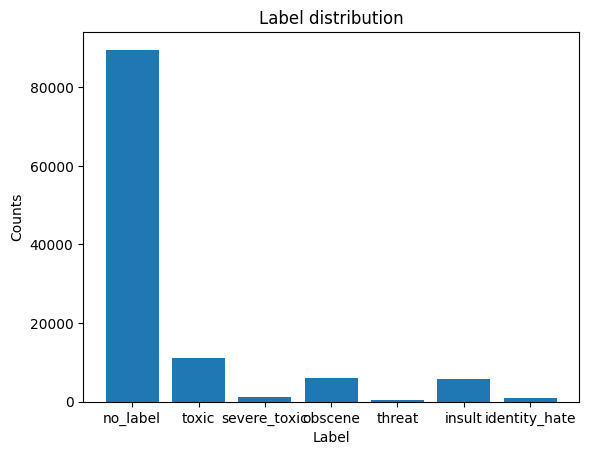

N. UNIQUE samples for target:
[('toxic', 4045), ('severe_toxic', 0), ('obscene', 227), ('threat', 15), ('insult', 210), ('identity_hate', 31)]

2/6--Text preprocessing
Done


3/6--Data augmentation
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Augmentation for label: toxic


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


[1 0 0 0 0 0]
Label severe_toxic not augmented
Augmentation for label: obscene
[0 0 1 0 0 0]
Augmentation for label: threat
[0 0 0 1 0 0]
Augmentation for label: insult
[0 0 0 0 1 0]
Augmentation for label: identity_hate
[0 0 0 0 0 1]
x_train lenght before augmentatoin: 114890
x_train lenght after augmentatoin: 131505
N. samples for target:
[('toxic', 11012), ('severe_toxic', 1137), ('obscene', 7445), ('threat', 7469), ('insult', 7352), ('identity_hate', 7460)]

N. samples with label: 41875, N. of sample withount label: 89630, Ratio neutral/label: 2.14


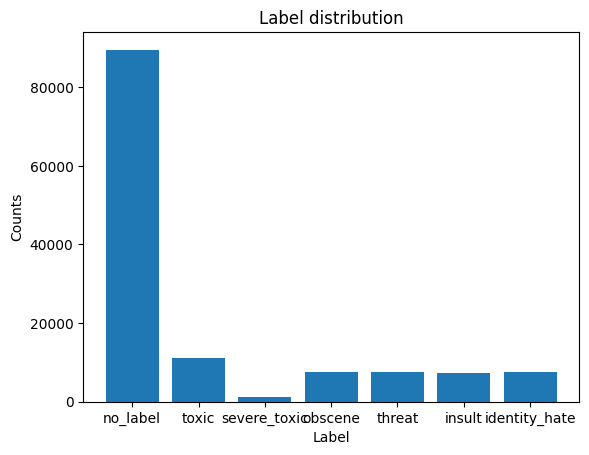

N. UNIQUE samples for target:
[('toxic', 4045), ('severe_toxic', 0), ('obscene', 1589), ('threat', 7140), ('insult', 1890), ('identity_hate', 6479)]

Done


4/6--Tokenizer
Done


5/6--Padding
max_lenght non padded seq: 1250
Done


6/6--Embeddings
Done
Quantities saved on file


In [ ]:
# data processing on train and val sets
data_preparation(x_train, x_val, x_test, y_train, y_val, y_test)

##**Analisi dati aumentati**

Come si può vedere dai grafici precedenti, la data augmentation ha reso le labels minoritarie più numerose, basandosi sui samples dove la data label è l'unica presente. Il problema sorge quando una label è presente solo su sample in combinazione con altre labels e quindi l'augmentation per come è stata definita non può essere applicata. Questo è il caso della label 'severe_toxic' che non dispone di dati a unico label. Il risultato è che questa label sarà un punto sicuramente debole dei modelli, portando a difficoltà di identificazione.

In [ ]:
#load data and utils
train_data=np.load('/content/drive/MyDrive/deep learning/train_data.npz')
x_train_pad = train_data['x_train']
y_train = train_data['y_train']

val_data=np.load('/content/drive/MyDrive/deep learning/val_data.npz')
x_val_pad = val_data['x_val']
y_val = val_data['y_val']

test_data=np.load('/content/drive/MyDrive/deep learning/test_data.npz')
x_test_pad = test_data['x_test']
y_test = test_data['y_test']

embedding_matrix=np.load('/content/drive/MyDrive/deep learning/embedding_matrix.npy')
embedding_dim=embedding_matrix.shape[1]


with open('/content/drive/MyDrive/deep learning/utils_dict.pkl', 'rb') as f:
    utils_dict = pickle.load(f)

vocab_size=utils_dict['vocab_size']
max_len=utils_dict['max_len']
sum_label_array_aug=utils_dict['sum_label_array_aug']


##**Caricamento dati salvati su disco**

Sempre per garantire sessioni di training indipendenti, una volta preprocessati i dati nei vari set, si salvano su disco e ora si caricano per allennare i modelli.

In [ ]:
# checking cleaned text (used for model testing)
with open(f'/content/drive/MyDrive/deep learning/x_val.pkl', 'rb') as f:
      x_val_test = pickle.load(f)
for i in range(10):
        print(f"{i+1}) {x_val_test[i]}")

1) get fucked get fuckeeed got drink cant put get fuck get fucked fucked right
2) band page deletion thought gone deleting comment posted talk page delete feelings hasty decision delete page sir still cock sucking douche fuck sit back second think life become done take long nope certainly aware life shitstorm sitting front computer masturbating fictional creatures attempts get rid mediocre best constantly sucking dick failure want personal attack huh well bad fuckcock mcdickerson got one go ahead delete profile wikipedia make another one come right back syrthiss talk page insult dick could shatter dreams innocent eighteen year old college freshman trying make name band make happy fucking people overweight single old man dead end job spot perhaps someone else going follow dreams trying hold back somebody else could suffer like yes make empty threats saying anything along lines hurt eat children within sister womb say asshole son bitch mother fucking cock sucker go eat food drown sorrows

In [ ]:
# custom BCE
weights_list=weights_building(sum_label_array_aug, len(y_train))
weighted_loss = WeightedBinaryCrossentropy(weights_list)

#**LSTM**

In [ ]:
name='LSTM'

In [ ]:
# lstm training function
rnn_lstm=model_training_function(x_train_pad, y_train, 4, vocab_size, max_len, embedding_matrix, embedding_dim, name=name, validation_data=(x_val_pad, y_val))

Pretrained LSTM model found and loaded.
Metrics file recovered.
Epoch 1/4
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9144 - auc: 0.9686 - loss: 0.0088 - recall: 0.3843

Epoch 8: training auc=0.969, val_auc=0.980

Epoch 8: Learning rate is 1.15e-05

Epoch 8: val_auc not improved for 2 epochs.

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 4881s 2s/step - accuracy: 0.9144 - auc: 0.9686 - loss: 0.0088 - recall: 0.3843 - val_accuracy: 0.9883 - val_auc: 0.9797 - val_loss: 0.0059 - val_recall: 0.6494
Epoch 2/4
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9143 - auc: 0.9684 - loss: 0.0088 - recall: 0.3842

Epoch 9: training auc=0.969, val_auc=0.980

Epoch 9: Learning rate is 5.90e-06

Epoch 9: val_auc not improved for 3 epochs.


Epoch 9: Early stopping enabled after 3 epochs without improvement.

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 4816s 2s/step - accuracy: 0.9143 - auc: 0.9684 - loss: 0.0088 - recall: 0.3842 - val_accuracy: 0.9877 - val_auc: 0.9795 - val_loss: 0.0059 - val_recall: 0.654

In [ ]:
# loading trained lstm
rnn_lstm=load_model('/content/drive/MyDrive/deep learning/model_LSTM.keras',
                                 custom_objects={'WeightedBinaryCrossentropy':WeightedBinaryCrossentropy,
                                                 'CustomExponentialDecay':CustomExponentialDecay})

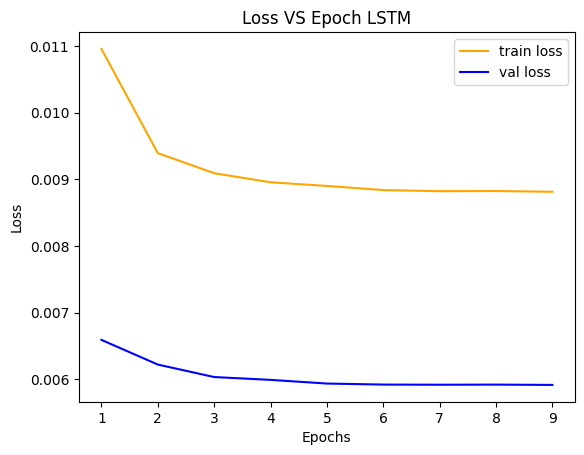

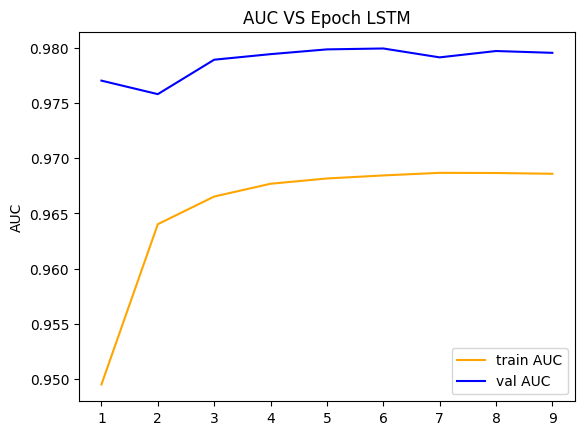

In [ ]:
# val metrics plot
val_metrics_plot(name)

Come si può osservare, la loss diminuisce all'avanzare del numero di epoche, testimoniando che il modello sta imparando. L'AUC, che indica quanto il modello è migliore rispetto ad un classificatore casuale, cresce durante il trainig, manifestando alcune piccole oscillazioni sul set di validation. In generale, il modello risulta ben addestrato dato che la sua AUC tende ad 1.  

Nel seguito, si possono vedere in dettaglio ulteriori metriche legate al modello e la bontà delle sue predizioni sia su validation che su test sets. Dai classification reports, si nota come il modello risulti meno efficiente sulla label 'sever_toxic', come previsto.
Inoltre, 'threat' risulta avere metriche tendenti a zero: questo è forse dovuto alla soglia usata per convertire le probabilità di predizione in labels binarie. Infatti, abbassando la soglia da 0.5 a 0.3 le metriche iniziano a discostarsi da 0. Inoltre, altra motivazione potrebbe essere la troppa augmentation, infatti si partiva da 15 samples con unica label 'threat' e si sono aumentati fino a oltre 7000. Quindi, l'eccessiva astrazione dei dati finali, troppo sintetici, ha reso il modello poco performante su questa label.
Infine, dato che abbassare la soglia di classificazione sembra giovare sul set di validazione ma non su quello di test, si sceglie di lasciare la soglia al default di 0.5 anche per gli altri modelli, sui quali si rileva lo stesso problema.

In generale, si può notare come il modello LSTM sia abbastanza performante nel prevedere le giuste labels sui dati di esempio testati.

In [ ]:
# metric analysis: val
metric_analysis(rnn_lstm, x_val_pad, y_val, 'val', ml_target, thresh=0.3)

399/399 ━━━━━━━━━━━━━━━━━━━━ 146s 366ms/step
Analysis on val set
               precision    recall  f1-score   support

        toxic       0.73      0.82      0.77      1223
 severe_toxic       0.45      0.52      0.48       139
      obscene       0.74      0.85      0.79       676
       threat       0.07      0.03      0.04        38
       insult       0.63      0.79      0.70       630
identity_hate       0.38      0.25      0.30       112

    micro avg       0.68      0.77      0.72      2818
    macro avg       0.50      0.54      0.51      2818
 weighted avg       0.67      0.77      0.72      2818
  samples avg       0.07      0.07      0.07      2818

1) get fucked get fuckeeed got drink cant put get fuck get fucked fucked right
y_true: ['toxic', 'obscene']
y_pred: ['toxic', 'severe_toxic', 'obscene', 'insult']


2) band page deletion thought gone deleting comment posted talk page delete feelings hasty decision delete page sir still cock sucking douche fuck sit back second

In [ ]:
# metric analysis: test
metric_analysis(rnn_lstm, x_test_pad, y_test, 'test', ml_target, thresh=0.3)

998/998 ━━━━━━━━━━━━━━━━━━━━ 442s 442ms/step
Analysis on test set
               precision    recall  f1-score   support

        toxic       0.73      0.81      0.77      3059
 severe_toxic       0.45      0.60      0.51       319
      obscene       0.73      0.85      0.79      1690
       threat       0.00      0.00      0.00        96
       insult       0.63      0.78      0.70      1575
identity_hate       0.43      0.30      0.35       281

    micro avg       0.68      0.77      0.72      7020
    macro avg       0.50      0.56      0.52      7020
 weighted avg       0.67      0.77      0.72      7020
  samples avg       0.07      0.07      0.07      7020

1) cocksucker piss around work
y_true: ['toxic', 'severe_toxic', 'obscene', 'insult']
y_pred: ['toxic', 'obscene', 'insult']


2) hey talk exclusive group wp talibans good destroying self appointed purist gang one asks questions abt anti social destructive non contribution wp ask sityush clean behavior issue nonsensical warn

#**GRU**

In [ ]:
name='GRU'

In [ ]:
# GRU training function
rnn_gru=model_training_function(x_train_pad, y_train, 5, vocab_size, max_len, embedding_matrix, embedding_dim, name=name, validation_data=(x_val_pad, y_val))

Pretrained GRU model found and loaded.
Metrics file recovered.
Epoch 1/5
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9019 - auc: 0.9682 - loss: 0.0089 - recall: 0.3891

Epoch 4: training auc=0.968, val_auc=0.980

Epoch 4: Learning rate is 8.59e-05

Epoch 4: val_auc improvement. From 0.980 to 0.980.

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 5236s 3s/step - accuracy: 0.9019 - auc: 0.9682 - loss: 0.0089 - recall: 0.3891 - val_accuracy: 0.9831 - val_auc: 0.9801 - val_loss: 0.0059 - val_recall: 0.6611
Epoch 2/5
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9002 - auc: 0.9692 - loss: 0.0089 - recall: 0.3853

Epoch 5: training auc=0.969, val_auc=0.980

Epoch 5: Learning rate is 4.40e-05

Epoch 5: val_auc improvement. From 0.980 to 0.980.

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 5430s 3s/step - accuracy: 0.9002 - auc: 0.9692 - loss: 0.0089 - recall: 0.3853 - val_accuracy: 0.9824 - val_auc: 0.9801 - val_loss: 0.0059 - val_recall: 0.6608
Epoch 3/5
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - a

In [ ]:
# loading trained gru
rnn_gru=load_model('/content/drive/MyDrive/deep learning/model_GRU.keras',
                                 custom_objects={'WeightedBinaryCrossentropy':WeightedBinaryCrossentropy,
                                                 'CustomExponentialDecay':CustomExponentialDecay})

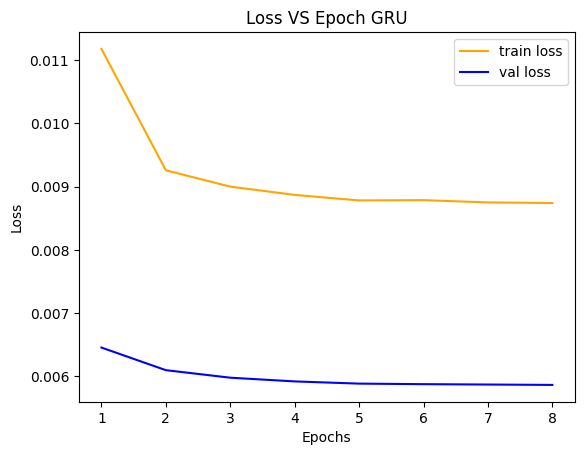

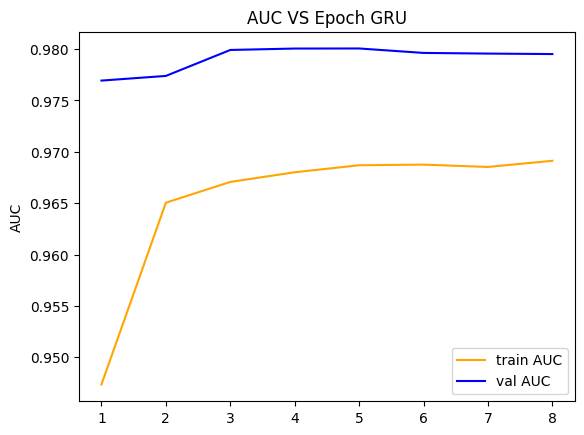

In [ ]:
# val metrics plot
val_metrics_plot(name)

Anche per il GRU la loss diminuisce all'avanzare del numero di epoche, testimoniando che il modello sta imparando. L'AUC aumenta durante il trainig. In generale, il modello risulta ben addestrato dato che la sua AUC tende a 1.  

Nel seguito, si possono vedere in dettaglio ulteriori metriche legate al modello e la bontà delle sue predizioni sia su validation che su test sets. Dai classification reports, si nota come il modello risulti simile in termini di performance all'LSTM. In particolare, non si evidenziano differenze dal punto di vista della performance,nè da quello della velocità di training, essendo la durata delle epoche comparabile a quella dell'LSTM. Questo è probabilmente legato al fatto che le architetture di rete in cui vengono usati i layers LSTM e GRU sono simili.

In generale, si può notare come anche il modello GRU sia ben performante nel prevedere le giuste labels sui dati di esempio testati.

In [ ]:
# metric analysis: val
metric_analysis(rnn_gru, x_val_pad, y_val, 'val', ml_target)

399/399 ━━━━━━━━━━━━━━━━━━━━ 161s 401ms/step
Analysis on val set
               precision    recall  f1-score   support

        toxic       0.85      0.73      0.78      1223
 severe_toxic       0.55      0.23      0.32       139
      obscene       0.82      0.78      0.80       676
       threat       0.00      0.00      0.00        38
       insult       0.71      0.66      0.68       630
identity_hate       0.50      0.01      0.02       112

    micro avg       0.80      0.66      0.72      2818
    macro avg       0.57      0.40      0.43      2818
 weighted avg       0.77      0.66      0.70      2818
  samples avg       0.06      0.06      0.06      2818

1) get fucked get fuckeeed got drink cant put get fuck get fucked fucked right
y_true: ['toxic', 'obscene']
y_pred: ['toxic', 'obscene', 'insult']


2) band page deletion thought gone deleting comment posted talk page delete feelings hasty decision delete page sir still cock sucking douche fuck sit back second think life beco

In [ ]:
# metric analysis: test
metric_analysis(rnn_gru, x_test_pad, y_test, 'test', ml_target)

998/998 ━━━━━━━━━━━━━━━━━━━━ 422s 423ms/step
Analysis on test set
               precision    recall  f1-score   support

        toxic       0.83      0.72      0.77      3059
 severe_toxic       0.58      0.35      0.44       319
      obscene       0.83      0.78      0.80      1690
       threat       0.00      0.00      0.00        96
       insult       0.72      0.66      0.69      1575
identity_hate       0.80      0.01      0.03       281

    micro avg       0.79      0.67      0.73      7020
    macro avg       0.63      0.42      0.45      7020
 weighted avg       0.78      0.67      0.71      7020
  samples avg       0.06      0.06      0.06      7020

1) cocksucker piss around work
y_true: ['toxic', 'severe_toxic', 'obscene', 'insult']
y_pred: ['toxic', 'obscene', 'insult']


2) hey talk exclusive group wp talibans good destroying self appointed purist gang one asks questions abt anti social destructive non contribution wp ask sityush clean behavior issue nonsensical warn

#**ENCODER + fully connected**

In [ ]:
name='ENCODER'

In [ ]:
# ENCODER training function
encoder=model_training_function(x_train_pad, y_train, 3, vocab_size, max_len, embedding_matrix, embedding_dim, name=name, validation_data=(x_val_pad, y_val))

Pretrained ENCODER model found and loaded.
Metrics file recovered.
Epoch 1/3
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9115 - auc: 0.9691 - loss: 0.0087 - recall: 0.3856

Epoch 10: training auc=0.970, val_auc=0.978

Epoch 10: Learning rate is 5.90e-06

Epoch 10: val_auc not improved for 2 epochs.

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 7751s 4s/step - accuracy: 0.9115 - auc: 0.9691 - loss: 0.0087 - recall: 0.3856 - val_accuracy: 0.9817 - val_auc: 0.9780 - val_loss: 0.0061 - val_recall: 0.6302
Epoch 2/3
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9137 - auc: 0.9698 - loss: 0.0087 - recall: 0.3897

Epoch 11: training auc=0.969, val_auc=0.978

Epoch 11: Learning rate is 3.02e-06

Epoch 11: val_auc not improved for 3 epochs.


Epoch 11: Early stopping enabled after 3 epochs without improvement.

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 7872s 4s/step - accuracy: 0.9137 - auc: 0.9698 - loss: 0.0087 - recall: 0.3897 - val_accuracy: 0.9819 - val_auc: 0.9781 - val_loss: 0.0061 - val_rec

In [ ]:
# loading trained encoder
encoder=load_model('/content/drive/MyDrive/deep learning/model_ENCODER.keras',
                                 custom_objects={'WeightedBinaryCrossentropy':WeightedBinaryCrossentropy,
                                                 'CustomExponentialDecay':CustomExponentialDecay,
                                                 'ExpandMask':ExpandMask})

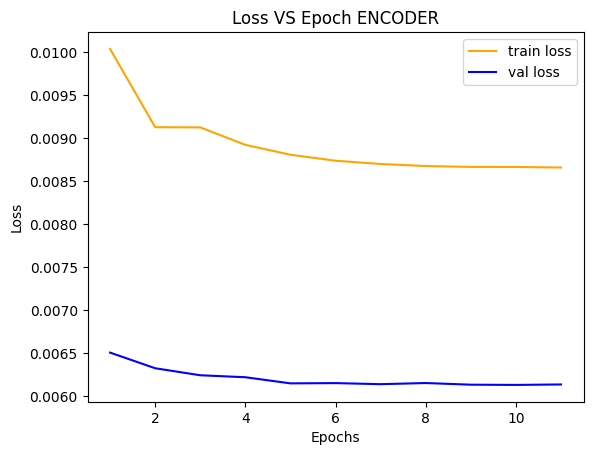

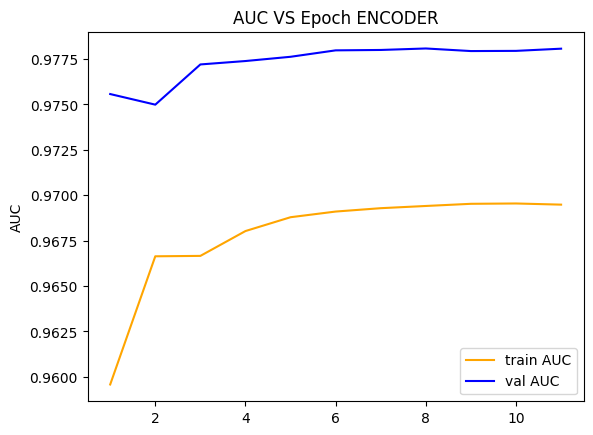

In [ ]:
# val metrics plot
val_metrics_plot(name)

Anche per l'Encoder la loss diminuisce all'avanzare del numero di epoche, testimoniando che il modello sta apprendendo. L'AUC cresce durante il training e il modello risulta ben addestrato, pur avendo una AUC leggermente inferiore ai casi precedenti.  

Nel seguito, si possono vedere in dettaglio ulteriori metriche legate al modello e la bontà delle sue predizioni sia su validation che su test sets. Dai classification reports, si nota come il modello risulta simile in termini di performance ai precedenti. Una differenza che salta all'occhio è sicuramente la capacità di prevedere meglio la label 'threat' a parità di soglia 0.5. Questo sottolinea il vantaggio che il meccanismo di attenzione può apportare, pur avendo inserito solo una testa di attenzione. Proprio in merito a questo, si può facilmente prevedere come l'encoder possa diventare migliore dei modelli ricorrenti aggiungendo più teste di attenzione.

In generale, il modello a encoder risulta adeguato nel prevedere le giuste labels sui dati di esempio testati, seppur con lievi mancanze rispetto ai modelli precedenti, specie sui dati con molte label coesistenti.

In [ ]:
# metric analysis: val
metric_analysis(encoder, x_val_pad, y_val, 'val', ml_target)

399/399 ━━━━━━━━━━━━━━━━━━━━ 333s 833ms/step
Analysis on val set
               precision    recall  f1-score   support

        toxic       0.84      0.69      0.76      1223
 severe_toxic       0.41      0.06      0.11       139
      obscene       0.85      0.76      0.80       676
       threat       0.67      0.05      0.10        38
       insult       0.71      0.64      0.67       630
identity_hate       0.81      0.12      0.20       112

    micro avg       0.81      0.63      0.71      2818
    macro avg       0.72      0.39      0.44      2818
 weighted avg       0.79      0.63      0.69      2818
  samples avg       0.06      0.06      0.06      2818

1) get fucked get fuckeeed got drink cant put get fuck get fucked fucked right
y_true: ['toxic', 'obscene']
y_pred: ['toxic', 'obscene', 'insult']


2) band page deletion thought gone deleting comment posted talk page delete feelings hasty decision delete page sir still cock sucking douche fuck sit back second think life beco

In [ ]:
# metric analysis: test
metric_analysis(encoder, x_test_pad, y_test, 'test', ml_target)

998/998 ━━━━━━━━━━━━━━━━━━━━ 873s 875ms/step
Analysis on test set
               precision    recall  f1-score   support

        toxic       0.84      0.70      0.76      3059
 severe_toxic       0.63      0.20      0.31       319
      obscene       0.85      0.75      0.80      1690
       threat       0.50      0.04      0.08        96
       insult       0.73      0.65      0.69      1575
identity_hate       0.76      0.12      0.21       281

    micro avg       0.81      0.64      0.72      7020
    macro avg       0.72      0.41      0.47      7020
 weighted avg       0.80      0.64      0.70      7020
  samples avg       0.06      0.06      0.06      7020

1) cocksucker piss around work
y_true: ['toxic', 'severe_toxic', 'obscene', 'insult']
y_pred: ['toxic', 'obscene', 'insult']


2) hey talk exclusive group wp talibans good destroying self appointed purist gang one asks questions abt anti social destructive non contribution wp ask sityush clean behavior issue nonsensical warn

##**Riferimenti**
1- Data augmentation in nlp (https://neptune.ai/blog/data-augmentation-nlp)

2- Embeddings preaddestrati (https://nlp.stanford.edu/projects/glove/)

3- binary cross entropy (A) (https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/)

4- binary cross entropy (B) (https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a/)